# CHARDA - Charge determination analysis

In [1]:
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors
import pandas as pd
import scipy.signal as ss
from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy import interpolate
from pyopenms import * 
from configobj import ConfigObj
import subprocess
import os
import IsoSpecPy
import h5py
import jdc
import warnings
from pandas.core.common import SettingWithCopyWarning
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
C13_Shift=1.0033548
Proton=1.0072764666

# Transient spectrum class 

## Init and clean up

In [4]:
class TransSpectrum:
    def __init__(self, TransData, name="Spectrum", build=True):
        self.trans = TransData
        self.name = name
        self.QuantFreq=3906250.0
        self.__A=2.11763959697e+14
        self.InitDeps()
        if build :
            self.MakeSpectrum()
            self.HalfSpecs()
            
    #Charnge calibration constant
    @property 
    def A(self):
        return self.__A
    
    @A.setter
    def A(self,A):
        self.__A=A
        self.InitDeps()
        self.MakeSpectrum()
        self.HalfSpecs()
        
    #initialize dependent arrays and variables
    def InitDeps(self):
        #Length of transient
        self.TrLen = len(self.trans)
        #Apodization arrays 
        #For full spectrum 
        self.KaiserArray=np.kaiser(self.TrLen,np.pi*3)
        #For half spectrum 
        self.KaiArray2=np.kaiser(self.TrLen//2,np.pi*3) #may migrate to half arrays
        #calibration array
        cscale=np.arange(self.TrLen)
        cscale[0]=1 #to avoid division by zero
        self.calib=self.A/np.square(cscale/(self.TrLen/self.QuantFreq))
        self.spaceX=np.linspace(800500.,3999500.,3200)
        
    def declb(self, mass):
        return (np.sqrt(self.A)*self.TrLen)/(np.sqrt(mass)*self.QuantFreq)

## Make spectrum

In [5]:
%%add_to TransSpectrum
def MakeSpectrum(self):
    self.SpecKai=fft(self.trans*self.KaiserArray)
    self.MagnKai=np.sqrt(self.SpecKai.real*self.SpecKai.real+self.SpecKai.imag*self.SpecKai.imag)

In [6]:
%%add_to TransSpectrum
def HalfSpecs(self):
    tr1=self.trans[:len(self.trans)//2]*self.KaiArray2
    tr2=self.trans[len(self.trans)//2:]*self.KaiArray2
    sp1=fft(tr1)
    sp2=fft(tr2)
    self.m1=np.sqrt(sp1.real*sp1.real+sp1.imag*sp1.imag)
    self.m2=np.sqrt(sp2.real*sp2.real+sp2.imag*sp2.imag)

In [7]:
%%add_to TransSpectrum
def SaveTransient(self, FileName):
    tfile=open(FileName,"w")
    tfile.write("{}\n".format(self.A))
    tfile.write("{}\n".format(self.QuantFreq))
    np.savetxt(tfile,self.trans,fmt="%f")
    tfile.close()

## Display Spectra

In [8]:
%%add_to TransSpectrum
def plotmasskai(self, minMass,maxMass,*args,PlotTo=None,labels=[],fname=None):
    if PlotTo is None:
        fig, ax = plt.subplots()
    else:
        ax = PlotTo
    #ax.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
    ax.locator_params(axis='x',nbins=6)
    ax.set_xlabel("m/z")
    ax.set_ylabel("Abundance, orb. units")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)        
    ax.plot(self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],
            self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],*args)
    #ax.plot(calib[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],
    #        MagnKai_std[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],*args)
    if len(labels)>0 :
        for mz,n in labels:
            if type(n)==float:
                ax.annotate("{:.2f}".format(n),(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
            else:    
                ax.annotate(n,(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
    if fname is not None:
        plt.savefig(fname)
    if PlotTo is None:
        plt.show()
        return plt
    else:
        return PlotTo

## Process Spectrum

In [9]:
%%add_to TransSpectrum
def spratio(self,center,points):
    centerf=int(np.round(((np.sqrt(self.A)*len(self.m1))/(np.sqrt(center)*self.QuantFreq))))
    minsp=centerf-points
    maxsp=centerf+points
    s1sum=np.sum(self.m1[minsp:maxsp+1])
    s2sum=np.sum(self.m2[minsp:maxsp+1])
    return s1sum/s2sum               

## Processing Functions

### Spectra and peaks

In [10]:
%%add_to TransSpectrum
def PeakPick(self,minMass,maxMass,sn=1.):
    self.peaks = None
    pp=PeakPickerHiRes()
    par=pp.getParameters()
    par.setValue('report_FWHM','true')
    par.setValue('signal_to_noise',sn)
    pp.setParameters(par)
    spectrum=MSSpectrum()
    spectrum.set_peaks([np.flip(self.calib[int(self.declb(maxMass)):int(self.declb(minMass))]),
                        np.flip(self.MagnKai[int(self.declb(maxMass)):int(self.declb(minMass))])])
    picked=MSSpectrum()
    pp.pick(spectrum, picked)
    #FWHM in ppms
    fda=picked.getFloatDataArrays()
    #mzs, intensities
    ppmz,ppints = picked.get_peaks()
    self.peaks=pd.DataFrame({"m/z":ppmz,"Intensity":ppints,"resolution":1000000./fda[0].get_data()})
    #return self.peaks

### Hardklor and products

In [11]:
class FullSpectrum(TransSpectrum):
    def RunHardKlor(self, **kwargs):
        hkconf=ConfigObj("hardklor_dump.conf", encoding='utf-8')
        hkconf.newlines = '\n'
        for key, value in kwargs.items():
            hkconf[key]=value
        newhkconf=open("hardklor.conf","wb") 
        hkconf.write(newhkconf)
        newhkconf.write("temp.mzXML /code/temp.hk ".encode('utf-8'))
        newhkconf.write("###".encode('utf-8'))
        newhkconf.close()
        spectrum=MSSpectrum()
        spectrum.set_peaks([np.array(self.peaks["m/z"]),np.array(self.peaks["Intensity"])])
        spectrum.setMSLevel(1)
        spectrum.setRT(1.0)
        spectrum.setName("1")
        spectrum.setType(2)
        spectrum.updateRanges()
        exp=MSExperiment()
        exp.addSpectrum(spectrum)
        mzFile=MzXMLFile()
        Options=mzFile.getOptions()
        Options.setForceMQCompatability(True)
        mzFile.setOptions(Options)
        mzFile.store("temp.mzXML",exp)
        subprocess.run(["./hardklor","hardklor.conf"])
        self.Clusters=pd.read_csv("temp.hk",sep="\t",skiprows=1,names=["Mass","Charge","Abundance","Base Peak","Interval","Correlation"],
                        usecols=[1,2,3,4,5,8])
        #return self.Clusters
    

In [12]:
def IonProducts(Clusters, sequence=None, ppm=10,Shift=0):
    Clusters["Ions"]=""
    Clusters["PPMError"]=0.
    Clusters["Shift"]=0
    Clusters["TheorMass"]=0.
    if isinstance(sequence,str):
        sequence=AASequence.fromString(sequence)
    ProductLabels=["a","b","c","x","y","z"]
    coverSet=[[]]*(sequence.size()-1)
    for i in range(1,sequence.size()-1):
        bpart=sequence.getPrefix(i)
        ypart=sequence.getSuffix(i)
        amass=bpart.getMonoWeight(Residue.ResidueType.AIon,0)
        bmass=bpart.getMonoWeight(Residue.ResidueType.BIon,0)
        cmass=bpart.getMonoWeight(Residue.ResidueType.CIon,0)
        xmass=ypart.getMonoWeight(Residue.ResidueType.XIon,0)
        ymass=ypart.getMonoWeight(Residue.ResidueType.YIon,0)
        zmass=ypart.getMonoWeight(Residue.ResidueType.ZIon,0)
        products=[amass,bmass,cmass,xmass,ymass,zmass]
        for label,product in zip(ProductLabels,products):
            for Sh in range(-Shift,Shift+1):
                Target=Clusters[Clusters["Mass"].between(product+Sh*1.003355-(product*ppm/1000000),product+Sh*1.003355+(product*ppm/1000000))]
                for row in Target.iterrows():
                    Clusters.at[row[0],"Ions"]="{}{}".format(label,i)
                    Clusters.at[row[0],"PPMError"]=(Clusters.at[row[0],"Mass"]-product-Sh*1.003355)*1000000./product
                    Clusters.at[row[0],"Shift"]=Sh
                    Clusters.at[row[0],"TheorMass"]=product
                    if label<"d":
                        #print("{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"]))
                        coverSet[i]=coverSet[i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
                    else:
                        coverSet[sequence.size()-i]=coverSet[sequence.size()-i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
    counter=0
    for i in range(sequence.size()-1):
        if len(coverSet[i])>0 :
            counter += 1
    cover=counter/(sequence.size()-1)
    return Clusters,coverSet,cover

In [13]:
%%add_to FullSpectrum
def Products(self, sequence=None, ppm=10,Shift=0):
    if sequence is None :
        sequence = self.sequence
    self.sequence = sequence
    self.Clusters,coverSet,cover = IonProducts(self.Clusters,self.sequence,ppm,Shift)
    return self.Clusters,coverSet,cover
    

### Filtering and joining

In [14]:
%%add_to TransSpectrum
def CheckIssues(self):
    self.peaks["issues"]=False
    for i in range(len(self.peaks)):
        mz=self.peaks.loc[i]["m/z"]
        margin=self.calib[int(self.declb(mz))]-self.calib[int(self.declb(mz))+5]
        diff=0
        for j in range(i-1,0,-1):
            diff=self.peaks.loc[i]["m/z"]-self.peaks.loc[j]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
        for j in range(i+1,len(self.peaks)):
            diff=self.peaks.loc[j]["m/z"]-self.peaks.loc[i]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
    return self.peaks
    #peaks.at[i,'left']=peaks.loc[i]['m/z']-margin        
    #peaks.at[i,'right']=peaks.loc[i]['m/z']+margin            

In [15]:
%%add_to FullSpectrum
def PeakstoClusters(self):
    links = 0
    counter=0
    for row in self.Clusters.iterrows():
        #10 ppm acceptable error
        ppms=row[1]["Base Peak"]/100000
        #take peaks in 5 Da interval from MonoMZ (plus errors)
        IntervPair=row[1].Interval.split('-')
        localpeak=self.peaks[(self.peaks['m/z']>float(IntervPair[0])-ppms) & (self.peaks['m/z']<float(IntervPair[1])+ppms)]
        #Mass difference to monoisotopic mass (not m/z!)
        localpeak["rest"]=(localpeak['m/z']-Proton)*row[1].Charge-row[1].Mass
        #Isotope number
        localpeak["Number"]=np.round(localpeak["rest"]/C13_Shift).astype(int)
        #Mass shift from nearest isotope
        localpeak.loc[:,["rest"]]=localpeak["rest"]-np.round(localpeak["rest"])*C13_Shift
        #Only peaks in acceptible error range from nearest Isotope allowed
        localpeak=localpeak[np.abs(localpeak['rest'])<ppms*row[1].Charge]
        #try to select consequent peaks
        toGet=[]
        #looking for consequtive peaks where most intense for isotope the same as most accurate 
        #high mass clusters (mass>20000) could be lost of low intensity first peaks
        #processed from maximum peak back and forth - stops when intensity is growing 
        #most abundant isotope number 
        start=int((row[1]["Base Peak"]-Proton)*row[1]["Charge"]-row[1]["Mass"])
        #print(start)
        LastInt=1.e20
        #print(localpeak)
        for i in range(start,-1,-1):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.insert(0,IntMax)
        LastInt=1.e20
        for i in range(start,20):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                #print(lp.loc[IntMax]["Intensity"],LastInt)
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.append(IntMax)
        toGet=list(set(toGet))
        toGet.sort()
        #print(toGet)
        if toGet is None :
            continue
        localpeak=localpeak.loc[toGet]
        link=pd.DataFrame({"cluster" :np.full(len(localpeak),row[0]),
                           "peak" : localpeak.index,
                           "number" : localpeak["Number"],
                           "rest" : localpeak["rest"],
                           "intensity" : localpeak["Intensity"]})
        #print(link)
        if isinstance(links,int) :
            links = link
        else:
            links=links.append(link)
        counter+=1
        #if counter>10:
            #break
    #print(links)
    self.links = links
    peaksref=self.peaks.join(self.links.set_index('peak'),how='inner')
    self.RPeaks=peaksref.join(self.Clusters,how='inner',on='cluster',lsuffix='_peak')    
    #return links

In [16]:
%%add_to FullSpectrum
def UsualProcessing(self):
    self.PeakPick(250,2500)
    self.CheckIssues()
    self.RunHardKlor(charge_min=1,charge_max=30)
    self.PeakstoClusters()

### Reverse FFT

In [17]:
%%add_to TransSpectrum
def taucalckai(self,minmass,maxmass,Print=False,Plot=None):
    arr=np.zeros(self.TrLen,dtype=np.complex)
    arr[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]=self.SpecKai[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]
    arr[int(np.round(-self.declb(minmass))):-int(np.round(self.declb(maxmass)))+1]=self.SpecKai[int(np.round(-self.declb(minmass))):int(np.round(-self.declb(maxmass)))+1]
    recsig=np.abs(ifft(arr)/self.KaiserArray)
    env=[np.average(recsig[int(i)-500:int(i+500)].real) for i in self.spaceX]
    s = stats.linregress(self.spaceX/self.QuantFreq,np.log(env))   
    if Print :
        if Plot is None:
            fig, ax = plt.subplots()
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
            ax.plot(self.spaceX/self.QuantFreq,env,label="signal envelope")#np.log(env))
            ax.plot(self.spaceX/self.QuantFreq,np.exp(s[0]*(self.spaceX/self.QuantFreq)+s[1]),label="exponent fit")
            ax.legend()
            plt.show()
        else:
            Plot.plot(self.spaceX/self.QuantFreq,np.log(env))
            Plot.plot(self.spaceX/self.QuantFreq,(self.spaceX/self.QuantFreq)*s[0]+s[1])
    return s

In [18]:
def FWHMCalc(Peaks):
    Peaks["FWHM"]=Peaks["m/z"]/Peaks["resolution"]
    Peaks["FWHM Coeff"]=np.power(Peaks["FWHM"],0.6666)/(Peaks["m/z"]*3.e-5)    
    return Peaks

In [19]:
%%add_to TransSpectrum
def TDACalc(self,Peaks=pd.DataFrame()):
    if Peaks.empty :
        Peaks = self.RPeaks
    
    Peaks["Slope"]=0.
    Peaks["Intercept"]=0.    
    Peaks["RSquare"]=0.
    Peaks["Ratio"]=0.0
    Peaks = FWHMCalc(Peaks)
    
    Peaks.reset_index(drop=True,inplace=True)


    for i in trange(len(Peaks)):
        center=int(np.round(self.declb(Peaks.iloc[i]["m/z"])))
        s=self.taucalckai(self.calib[center+5],self.calib[center-5])
        Peaks.at[i,"Slope"]=s[0]
        Peaks.at[i,"Intercept"]=s[1]    
        Peaks.at[i,"RSquare"]=s[2]
        Peaks.at[i,"Ratio"]=self.spratio(Peaks.iloc[i]['m/z'],5)
    return Peaks

### Show resolution

In [20]:
colors=["black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple"]

In [21]:
def ShowRes(Values,Charges,xlabel = "Predicted Charge",GaussianHeght=3,MinCharge=0,MaxCharge=0,fname=""):
    SigmaSum=0
    Counter=0
    if (MinCharge == 0):
        MinCharge = int(np.min(Charges))
    if (MaxCharge == 0):
        MaxCharge = int(np.max(Charges))
    MinValue = int(np.min(Values))
    MaxValue = np.max(Values)
    x = np.linspace(MinValue-(MaxValue-MinValue)/5.,MaxValue+(MaxValue-MinValue)/5.,200)
    print("Charge \tPeaks \t Mean \t Variance")
    for i in range(MinCharge,MaxCharge+1):
        Slopes=Values[Charges==i]
        if (len(Slopes)>=2):
            Params=stats.norm.fit(Slopes)
            print("{} \t{} \t{:6.3f} \t{:6.3f}".format(i,len(Slopes),Params[0],Params[1]))
            SigmaSum=SigmaSum+Params[1]
            Counter+=1
            fitted = stats.norm.pdf(x,loc = Params[0],scale = Params[1])
            fitted=(fitted/np.max(fitted))*GaussianHeght
            plt.plot(x,fitted,colors[i],label="Charge "+str(i)+" fit")
        plt.hist(Slopes,x,facecolor=colors[i],alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel)
    if (fname!=""):
        plt.savefig(fname)
    SigmaAve=SigmaSum/Counter
    FWHM=SigmaAve*2.355
    Res=MaxCharge/FWHM
    #Res=(MaxValue-MinValue)/FWHM
    print("Resolution: {:.2f}".format(Res))

### Regression

In [22]:
class Regression:
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True):
        self.NoMZ=NoMZ
        self.FWHM=FWHM
        self.Slope=Slope 
        self.X=self.FeatureExtraction(FRes)
        self.Fit(self.X,FRes["Charge"])
        
    def FeatureExtraction(self,FRes):
        X=pd.DataFrame()
        if self.Slope:
            X["Slope"]=FRes["Slope"]
            X["SlopelogIntens"]=FRes["Slope"]*np.log(FRes["Intensity"])
        X["LogRatio"]=np.log(FRes["Ratio"])
        X["RatiologIntens"]=np.log(FRes["Ratio"])*np.log(FRes["Intensity"])
        if (not self.NoMZ):
            if self.Slope:
                X["SlopeMZ"]=FRes["Slope"]*FRes["m/z"]
            X["LogRatioMZ"]=np.log(FRes["Ratio"])*FRes["m/z"]
        if self.FWHM:
            X["FWHM"] = FRes["FWHM Coeff"]
        return X
    
    def Fit(self,X,Y):
        return
    
    def Apply(self,FRes):
        return
    

In [23]:
class LinearReg(Regression):
    
    def Fit(self,X,Y):
        self.regr=linear_model.LinearRegression()
        self.regr.fit(X,Y)

    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        Y_pred=self.regr.predict(X)
        return Y_pred        

In [24]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

In [25]:
class LogisticReg(Regression):
    
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True,ClassThres=3):
        self.ClassThres = ClassThres
        Classes=np.sort(FRes["Charge"].unique())
        Enough=[ np.count_nonzero(FRes["Charge"]==n) >= ClassThres for n in Classes]
        self.Classes = Classes[Enough]
        FRes=FRes[np.isin(FRes["Charge"],self.Classes)]
        super().__init__(FRes,NoMZ,FWHM,Slope)
        
    def Fit(self,X,Y):
        self.scaler=StandardScaler()
        X_scaled=self.scaler.fit_transform(X)
        self.lr=LogisticRegression(solver="newton-cg" ,max_iter=100000, penalty="none")
        self.lr.fit(X_scaled,Y)
        
    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        X_scaled=self.scaler.transform(X)
        Y_distr=self.lr.predict_proba(X_scaled)
        Y=np.dot(Y_distr,self.Classes)
        return Y,Y_distr        
    
    def Estimate(self,FRes):
        Y,Y_distr=self.Apply(FRes)
        FRes["Aver"]=0.0
        FRes["Sigma"]=0.0
        for i in range(len(Y_distr)):
            FRes["Aver"].iat[i],FRes["Sigma"].iat[i]=weighted_avg_and_std(self.Classes,Y_distr[i])                
        return FRes

In [26]:
class MassLogisticReg(LogisticReg):
    
    MassDistr=pd.read_csv("/data/StatBar.csv",sep="\t")
    
    def Apply(self,FRes):
        Y,Y_distr=super().Apply(FRes)
        Y_mass_decay=np.copy(Y_distr)
        for i in range(len(Y_distr)):
            Y_mass_decay[i]=MassLogisticReg.MassDistr["0.2"][((FRes.loc[i]["m/z"]-1.007276467)*self.Classes*100).astype(int)]*Y_distr[i]
            Y_mass_decay[i]=Y_mass_decay[i]/np.sum(Y_mass_decay[i])
        Y=np.dot(Y_mass_decay,self.Classes)
        return Y,Y_mass_decay        

### Spectra visualization

In [27]:
%%add_to TransSpectrum
def RainbowSpectrum(self,minMass,maxMass,FPeaks,minCharge=1,maxCharge=8,
                    Name="Spectrum",LabelThres=0.15,ColorThres=0.02,svg=False):
#Peaks is a Dataframe and should have columns "Intensity","m/z","Aver","Sigma"

    plt.rcParams["figure.figsize"] = (18,6)
    plt.rcParams.update({'font.size': 14})

    #build a curve to show
    highest=np.max(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1])
    yvalues=100.*(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]/highest)
    xvalues=self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]
    xvalues=xvalues[::-1]
    yvalues=yvalues[::-1]
    
    #select peaks to color
    Peaks=FPeaks[(FPeaks["m/z"]>minMass) & (FPeaks["m/z"]<maxMass)]
    highestPeak=np.max(Peaks["Intensity"])
    PeakstoShow=Peaks[Peaks["Intensity"]>highestPeak*LabelThres] [["m/z","Aver","Sigma"]]
    PeakstoShow["Label"]=""
    for row in PeakstoShow.iterrows():
        PeakstoShow["Label"].at[row[0]]=u'{:.1f}\xB1{:.1f}'.format(row[1]["Aver"],row[1]["Sigma"])#*2.0)
    PeakstoShow=PeakstoShow.drop(columns=["Aver","Sigma"])
    labels=[tuple(x[1]) for x in PeakstoShow.iterrows()]
    #first color more intensive peaks 
    Peaks=Peaks.sort_values("Intensity")
    charges=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["Aver"])
    mzs=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["m/z"])

    #peaks will be colored from maximum to closest minimal local extremum - here we select extrema
    mins=ss.argrelmin(yvalues)
    minmzs=xvalues[mins]

    #Array for colors - by default color is gray
    colorD=np.zeros(len(xvalues))
    colorD[:]=maxCharge*1.2 ##!!Default color MaxCharge+const???

    #here we apply the colors
    for i in range(len(mzs)):
        index = minmzs.searchsorted(mzs[i])
        if index>0 and index<len(minmzs)-1: 
            colorD[mins[0][index-1]:mins[0][index]]=maxCharge-charges[i]


    #Build the curve
    points = np.array([xvalues, yvalues]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    vmin=minCharge-((maxCharge-minCharge)/8)-1
    vmax=maxCharge+((maxCharge-minCharge)/8)-1
    print(vmin,vmax)
    norm = plt.Normalize(vmin, vmax)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)

    fig, axs = plt.subplots(1, 1)

    lc.set_array(colorD)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)


    norm1 = matplotlib.colors.Normalize(vmin=minCharge, vmax = maxCharge)
    cmap = plt.get_cmap('nipy_spectral')
    #colors = cmap(np.linspace(1/1.1, 1-1/1.1, cmap.N))
    colors = cmap(np.linspace(0.9, 0.1, cmap.N))
    color_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_jet', colors)
    cax, _  = matplotlib.colorbar.make_axes(plt.gca())
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm1)

    axs.get_xaxis().get_major_formatter().set_useOffset(False)
    axs.get_yaxis().get_major_formatter().set_useOffset(False)
    axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
    axs.locator_params(axis='x',nbins=6)
    axs.set_xlabel("m/z")
    axs.set_ylabel("Abundance, %")
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)

    #for mz,n in labels:
    #    axs.annotate(n,(mz,100.*(MagnKai[int(np.round(declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )


    axs.set_xlim(minMass, maxMass)
    axs.set_ylim(0,100.)

    for mz,n in labels:
        axs.annotate(n,(mz,100.*(self.MagnKai[int(np.round(self.declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )

    if (svg):
        plt.savefig(Name+".svg")

    plt.show()

### Isotope modeling

In [28]:
def IsoSim(Formula, Charge, IsoNumber,tau):
    A=2.11762200881e+14
    QuantFreq=4000000.0
    TrLen=6000000
    Pr=1.007276466
    H=1.007825032    
    cscale=np.arange(TrLen)
    #cscale[0]=1 #to avoid division by zero
    #Get all isotopolues probabilies and convert them to DataFrame
    i = IsoSpecPy.IsoTotalProb(formula=Formula, prob_to_cover = 0.9999, get_confs=True)
    IsoDist=pd.DataFrame([[mass, prob] + list(sum(conf,())) for mass, prob, conf in i], 
                 columns=["Mass","Prob","C12","C13","H","D","N14","N15","O16","O17","O18","S32","S33","S34","S36"])
    #calc isotopу peak number for each isotopologue
    IsoDist["IsoLog"]=IsoDist.C13+IsoDist.D+IsoDist.N15+IsoDist.O17+IsoDist.O18*2+IsoDist.S33+IsoDist.S34*2+IsoDist.S36*4
    #calc m/z, frequences and intensities of FFT signal 
    IsoDist["m/z"]=(IsoDist.Mass+H)/Charge+Pr
    masses=list(IsoDist[IsoDist.IsoLog==IsoNumber]["m/z"])
    fr=[(np.sqrt(A)*TrLen)/(np.sqrt(mass)*QuantFreq) for mass in masses]
    ints=IsoDist[IsoDist.IsoLog==IsoNumber]["Prob"]
    #form oscillating signal and spectrum
    signal=np.zeros(TrLen)
    for f,i in zip(fr,ints):
        signal=signal+i*np.cos((f/TrLen)*cscale*2*np.pi)*np.exp(-(tau*cscale)/QuantFreq)#tau<->0.0
    return signal,IsoDist[IsoDist.IsoLog==IsoNumber]

## Pictures for journal

### Figure 1

In [29]:
UbiSpec = FullSpectrum(np.loadtxt("/data/2-ubiq_1e5_1-850_chB_r_transient_0-1500ms.csv",skiprows=2)[1000:5895500])

In [30]:
plt.rcParams["figure.figsize"] = (8,6)

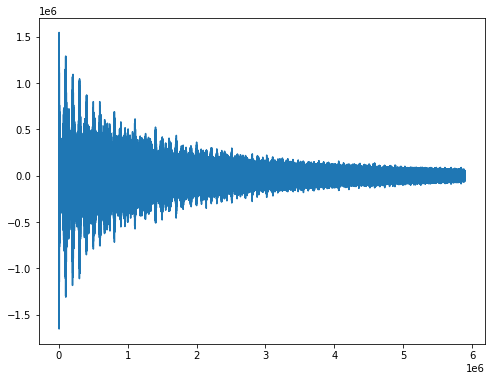

In [31]:
plt.plot(UbiSpec.trans)
plt.savefig("/results/Panel1-1.svg")

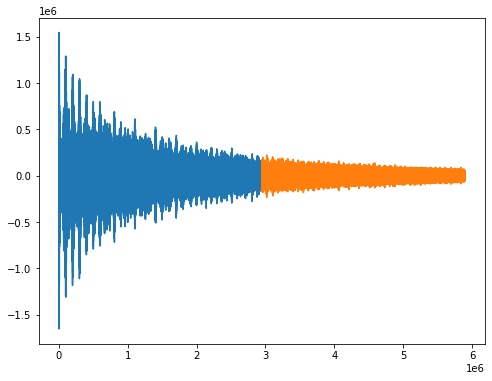

In [32]:
plt.plot(np.arange(UbiSpec.TrLen//2),UbiSpec.trans[0:UbiSpec.TrLen//2])
plt.plot(np.arange(UbiSpec.TrLen//2,UbiSpec.TrLen),UbiSpec.trans[UbiSpec.TrLen//2:UbiSpec.TrLen])

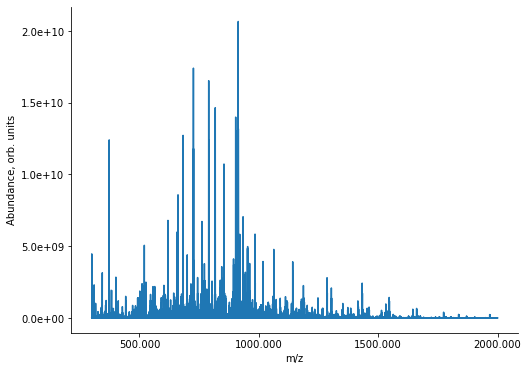

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [33]:
UbiSpec.plotmasskai(300,2000,fname="/results/Panel1-2.svg")

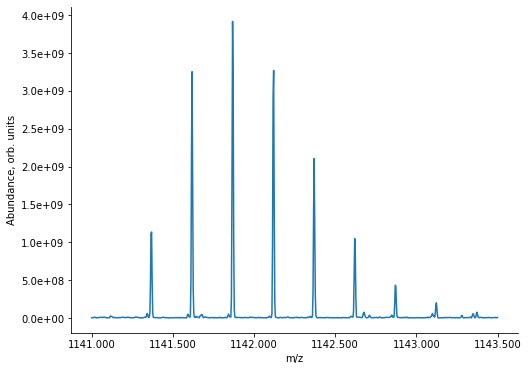

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [34]:
UbiSpec.plotmasskai(1141,1143.5,fname="/results/Panel1-3.svg")

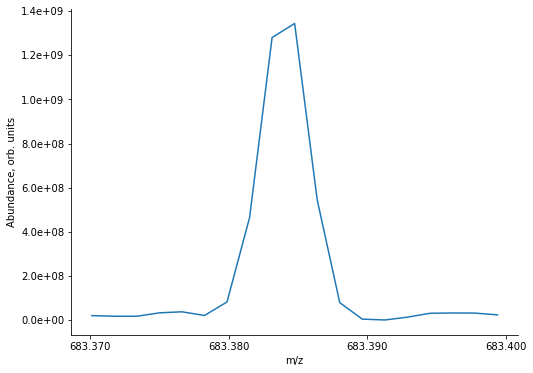

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [35]:
UbiSpec.plotmasskai(683.37,683.4,fname="/results/Panel1-4.svg")

### Figure 2 and Suplementary Figure 1

In [36]:
UbiSpec.UsualProcessing()

In [37]:
_,coverSet,cover=UbiSpec.Products(sequence="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG")

In [38]:
coverSet

[[],
 [],
 [],
 ['b3 1+'],
 ['a4 1+', 'b4 1+'],
 ['a5 1+', 'b5 1+', 'c5 1+'],
 ['b6 2+', 'b6 1+'],
 ['b7 1+'],
 ['a8 2+', 'a8 1+', 'b8 2+', 'b8 1+'],
 ['a9 2+', 'a9 1+', 'b9 2+', 'b9 1+'],
 ['b10 1+', 'c10 2+', 'c10 1+'],
 ['b11 2+', 'b11 1+', 'c11 1+'],
 ['b12 2+', 'b12 1+', 'c12 1+'],
 ['a13 2+', 'b13 2+', 'b13 1+'],
 ['a14 3+', 'a14 2+', 'b14 3+', 'b14 2+', 'b14 1+', 'c14 1+'],
 ['a15 3+', 'a15 2+', 'b15 3+', 'b15 2+', 'b15 1+', 'y61 7+'],
 ['a16 3+', 'a16 2+', 'b16 3+', 'b16 2+', 'b16 1+', 'y60 7+'],
 ['a17 3+', 'a17 2+', 'b17 3+', 'b17 2+', 'b17 1+'],
 ['a18 2+',
  'b18 3+',
  'b18 2+',
  'b18 1+',
  'y58 9+',
  'y58 8+',
  'y58 7+',
  'y58 6+',
  'z58 9+'],
 ['y57 7+'],
 ['b20 2+', 'y56 8+', 'y56 7+', 'y56 6+'],
 ['y55 8+', 'y55 7+'],
 ['b22 2+', 'y54 8+', 'y54 7+', 'y54 6+', 'y54 5+'],
 ['b23 2+', 'y53 8+', 'y53 7+', 'y53 6+', 'y53 5+'],
 ['y52 8+', 'y52 7+', 'y52 6+', 'z52 8+', 'z52 7+', 'z52 6+'],
 ['b25 2+', 'y51 7+', 'y51 6+'],
 ['y50 7+', 'y50 6+', 'y50 5+'],
 ['y49 7+', 'y

In [39]:
cover

0.92

In [40]:
UbiSpec.PeakstoClusters()

In [41]:
len(UbiSpec.RPeaks[UbiSpec.RPeaks["Ions"]!=""])

1167

In [42]:
len(UbiSpec.Clusters[UbiSpec.Clusters["Ions"]!=""])

212

In [43]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [44]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["number"]==0]

In [45]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [46]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [47]:
_=UbiSpec.TDACalc()

In [48]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]

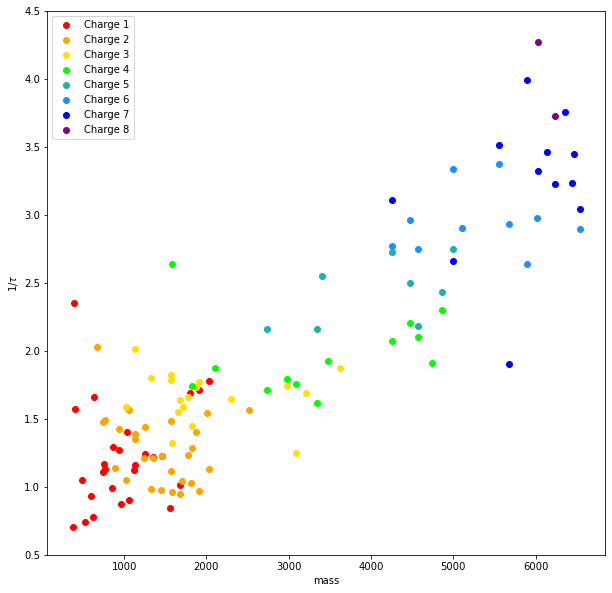

In [49]:
Counter=0
plt.rcParams["figure.figsize"] = (10,10)
for i in range(1,9):
    Yscat=-FRes["Slope"][FRes["Charge"]==i]
    Xscat=FRes["m/z"][FRes["Charge"]==i]*i
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("mass")
plt.ylabel(r"1/$\tau$")
#plt.xlim(800,860)
plt.ylim(0.5,4.5)
plt.savefig("/results/Panel2-1.svg")
plt.show()

In [50]:
UbiSpec.PeakstoClusters()

In [51]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [52]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [53]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [54]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks.Intensity>1.0e08]

In [55]:
_ = UbiSpec.TDACalc()

In [56]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]

In [57]:
FWHMstd=np.std(FRes["FWHM Coeff"])

In [58]:
FWHMmean=np.mean(FRes["FWHM Coeff"])

In [59]:
FRes=FRes[(FRes["FWHM Coeff"]<FWHMmean+3*FWHMstd) & (FRes["FWHM Coeff"]>FWHMmean-3*FWHMstd)]

In [60]:
lr=LogisticReg(FRes,FWHM=True)
Y,Y_Distr=lr.Apply(FRes)

In [61]:
plt.rcParams["figure.figsize"] = (13,8)

Charge 	Peaks 	 Mean 	 Variance
1 	46 	 1.230 	 0.348
2 	80 	 2.292 	 0.504
3 	60 	 2.951 	 0.628
4 	65 	 4.184 	 0.929
5 	54 	 5.242 	 0.781
6 	79 	 5.876 	 0.699
7 	101 	 6.699 	 0.556
8 	36 	 7.616 	 0.451
Resolution: 5.55


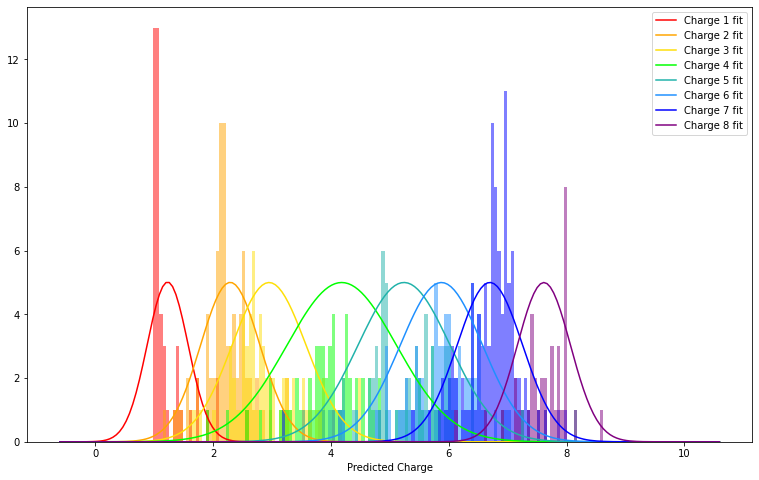

In [62]:
ShowRes(Y,FRes["Charge"],MaxCharge=8,GaussianHeght=5,fname="/results/Panel2-2.svg")

In [63]:
lrm=MassLogisticReg(FRes,FWHM=True)
FRes.reset_index(inplace=True,drop=True)
Y_pred_mass,Y_pred_Distr=lrm.Apply(FRes)

Charge 	Peaks 	 Mean 	 Variance
1 	46 	 1.163 	 0.302
2 	80 	 2.153 	 0.496
3 	60 	 3.056 	 0.566
4 	65 	 4.204 	 0.803
5 	54 	 5.275 	 0.677
6 	79 	 5.912 	 0.683
7 	101 	 6.739 	 0.570
8 	36 	 7.704 	 0.415
Resolution: 6.02


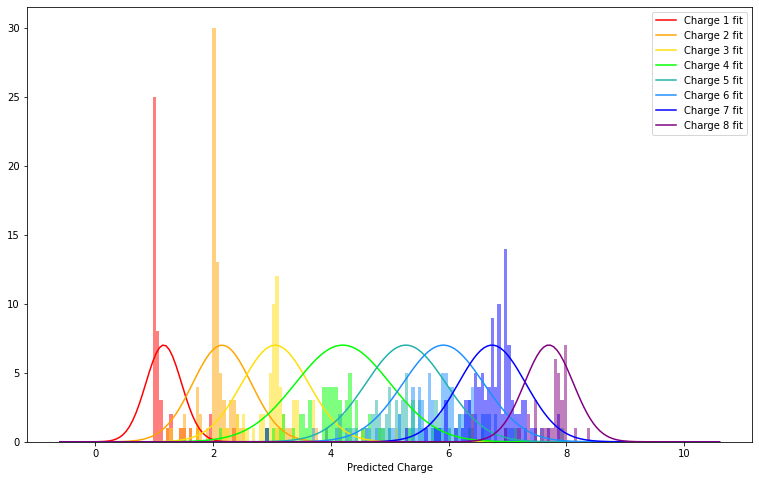

In [64]:
ShowRes(Y_pred_mass,FRes["Charge"],MaxCharge=8,GaussianHeght=7,fname="/results/PanelS1-1.svg")

### Figure 3

In [65]:
F3Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>811.)&(UbiSpec.peaks["m/z"]<813.5)]

In [66]:
F3Peaks=UbiSpec.TDACalc(Peaks=F3Peaks)

In [67]:
lr=MassLogisticReg(FRes,FWHM=True)
F3Peaks=lr.Estimate(F3Peaks)

-0.875 7.875


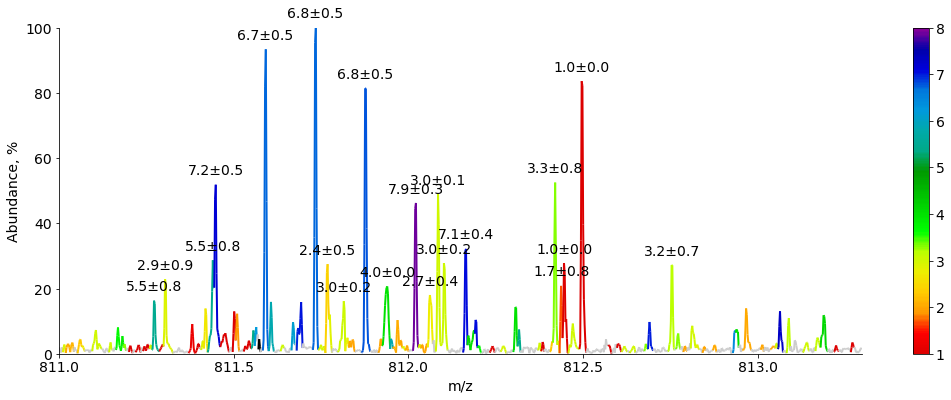

In [68]:
UbiSpec.RainbowSpectrum(811,813.3,F3Peaks,maxCharge=8,svg=True,Name="/results/Panel3-1")

In [69]:
lowPeaks=F3Peaks[F3Peaks["Aver"]<4.]
highPeaks=F3Peaks[F3Peaks["Aver"]>5.]
midPeaks=F3Peaks[F3Peaks["Aver"]<6.]
midPeaks=midPeaks[midPeaks["Aver"]>3.]

In [70]:
plt.rcParams["figure.figsize"] = (8,5)

In [71]:
F3MaxInt=np.max(F3Peaks["Intensity"])

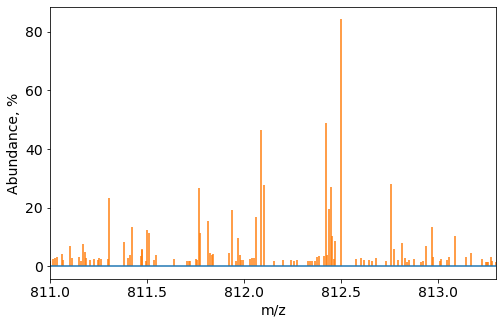

In [72]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(lowPeaks["m/z"],(lowPeaks["Intensity"]/F3MaxInt)*100.,"C1",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-2.svg")
plt.show()

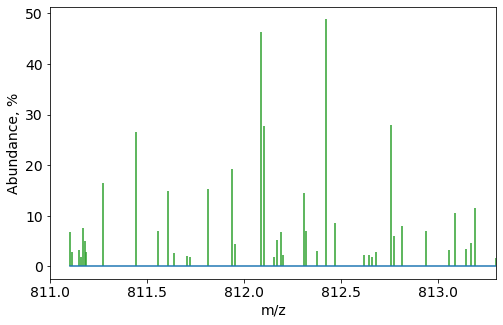

In [73]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(midPeaks["m/z"],(midPeaks["Intensity"]/F3MaxInt)*100.,"C2",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-3.svg")
plt.show()

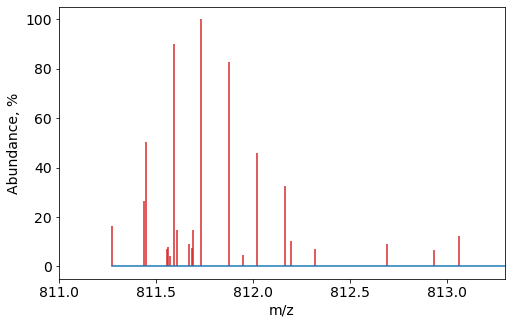

In [74]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(highPeaks["m/z"],(highPeaks["Intensity"]/F3MaxInt)*100.,"C3",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-4.svg")
plt.show()

### Figure 4

In [75]:
myhf=h5py.File("/data/CAH_MYO_NEO_averaged_transient_1.0s.h5","r")

In [76]:
CAHSingle=FullSpectrum((myhf["0"][:])[1000:4100000])

In [77]:
CAHSingle.PeakPick(119,2600,sn=3.)
CAHSingle.CheckIssues()
CAHSingle.RunHardKlor(charge_min=1,charge_max=40)

In [78]:
CAHSingle.Clusters.at[18,"Mass"]=29006.48
CAHSingle.Clusters.at[18,"Charge"]=34
CAHSingle.Clusters.at[47,"Mass"]=29006.48
CAHSingle.Clusters.at[47,"Charge"]=28
CAHSingle.Clusters.at[55,"Mass"]=29006.48
CAHSingle.Clusters.at[55,"Charge"]=26
CAHSingle.Clusters=CAHSingle.Clusters.drop([19,48])

In [79]:
_ = CAHSingle.TDACalc(Peaks=CAHSingle.peaks)

In [80]:
CAHSingle.PeakstoClusters()

In [81]:
CAHlr=LogisticReg(CAHSingle.RPeaks,NoMZ=True,FWHM=True)
Y,Y_Distr=CAHlr.Apply(CAHSingle.RPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	86 	 3.930 	 3.558
2 	2 	29.460 	 3.973
3 	2 	23.894 	 9.326
5 	3 	 5.208 	 4.137
6 	4 	 6.247 	 4.193
8 	4 	 6.771 	 3.425
9 	11 	 8.611 	 3.501
10 	8 	12.503 	 2.979
12 	10 	13.139 	 2.221
13 	12 	13.089 	 4.157
14 	20 	13.998 	 2.990
15 	20 	13.069 	 3.786
16 	20 	13.991 	 3.544
17 	12 	15.703 	 2.587
18 	12 	16.250 	 2.624
19 	15 	15.511 	 4.446
20 	14 	16.590 	 3.785
21 	13 	20.148 	 3.633
25 	5 	25.346 	 6.092
26 	6 	28.907 	 1.090
27 	8 	24.707 	 2.366
28 	8 	29.751 	 1.944
29 	3 	26.499 	 1.995
30 	10 	29.230 	 1.240
31 	7 	31.517 	 1.631
32 	8 	31.531 	 0.895
33 	10 	32.368 	 1.467
34 	12 	31.368 	 2.487
35 	9 	33.674 	 0.379
Resolution: 4.76


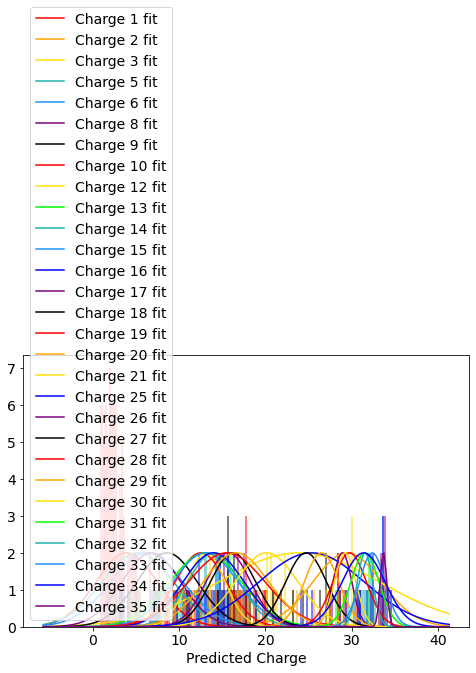

In [82]:
ShowRes(Y,CAHSingle.RPeaks["Charge"],MaxCharge=35,GaussianHeght=2)

In [83]:
CAHSingle.peaks=CAHlr.Estimate(CAHSingle.peaks)

-4.25 38.25


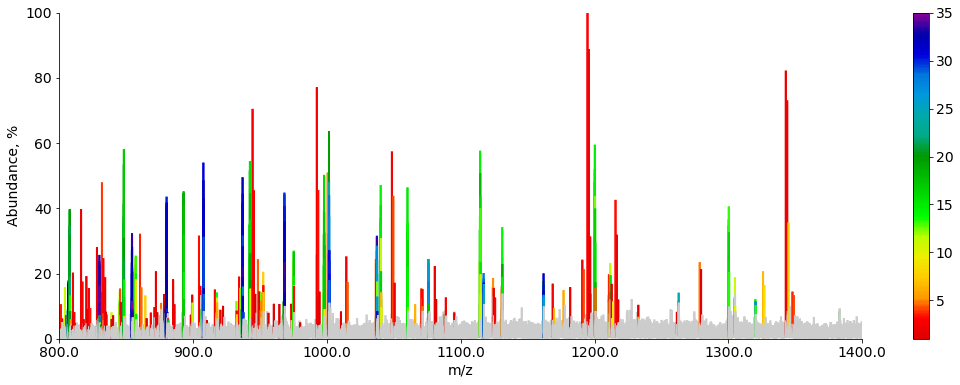

In [84]:
CAHSingle.RainbowSpectrum(800,1400,CAHSingle.peaks,maxCharge=35,LabelThres=1.,svg=True,Name="/results/Panel4-1")

In [85]:
F4Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>851) & (UbiSpec.peaks["m/z"]<854)]

In [86]:
F4Peaks=UbiSpec.TDACalc(Peaks=F4Peaks)

In [87]:
F4Peaks=lr.Estimate(F4Peaks)

-0.875 7.875


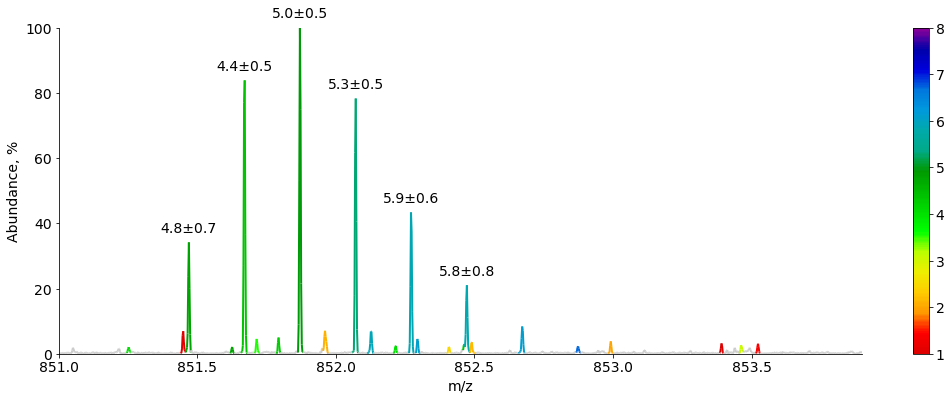

In [88]:
UbiSpec.RainbowSpectrum(851,853.9,F4Peaks,LabelThres=0.1,Name="/results/Panel4-2",svg=True)

In [89]:
omega=50
resolution=100
tau=0.01
s=np.arange(omega*resolution*2*np.pi)/resolution

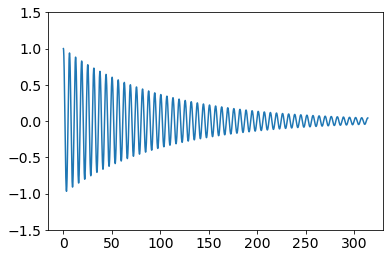

In [90]:
plt.rcParams["figure.figsize"] = (6,4)
plt.ylim(top=1.5, bottom=-1.5)
exp_sig1=np.cos(s)*np.exp(-(s*tau))
exp_sig2=np.cos(s*1.03)*np.exp(-(s*tau))
plt.plot(s,exp_sig1)
plt.savefig("/results/Panel4-3.svg")

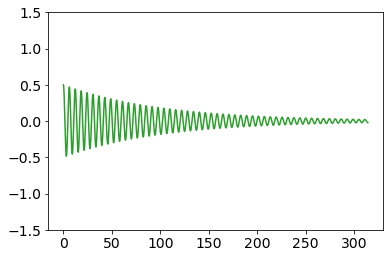

In [91]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("/results/Panel4-4.svg")

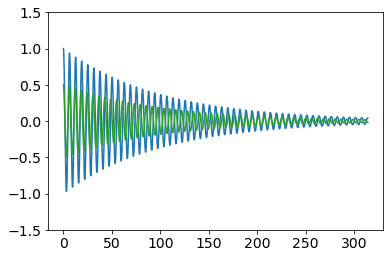

In [92]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig1,color="C0")
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("/results/Panel4-5.svg")

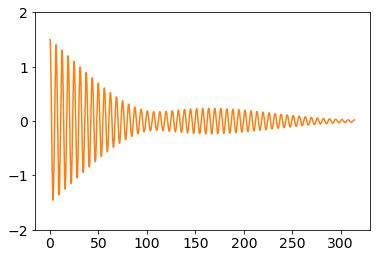

In [93]:
plt.ylim(top=2.0, bottom=-2.0)
plt.plot(s,exp_sig1+exp_sig2*0.5,color="C1")
plt.savefig("/results/Panel4-6.svg")

In [94]:
SimTransient,IsoDistr=IsoSim("C121H201N33O36S1",4,4,1.7)

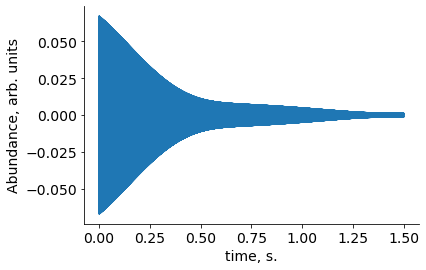

In [95]:
fig, ax = plt.subplots()
ax.set_xlabel("time, s.")
ax.set_ylabel("Abundance, arb. units")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        
plt.plot(np.arange(6000000)/4000000.0,SimTransient)
plt.savefig("/results/Panel4-7.svg")  

In [96]:
IsoDistr["Abu"]=100.*(IsoDistr["Prob"]/np.sum(IsoDistr["Prob"]))

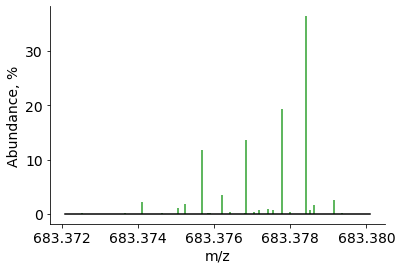

In [97]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax.locator_params(axis='x',nbins=5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        

#ax.set_xlim(811.,813.3)
ax.stem(IsoDistr["m/z"],IsoDistr["Abu"],"C2",markerfmt=" ", basefmt="black")
plt.savefig("/results/Panel4-8.svg")

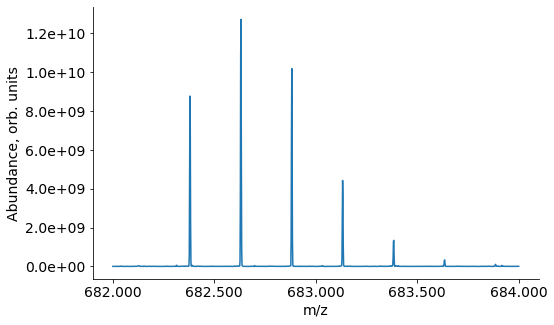

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [98]:
plt.rcParams["figure.figsize"] = (8,5)
UbiSpec.plotmasskai(682,684,fname="/results/Panel4-9.svg")

### Figure 5

In [99]:
FullSp=FullSpectrum(np.loadtxt("/data/DNA-binding protein HU-beta_std_pept.csv",skiprows=2)[1000:]+np.loadtxt("/data/DNA-binding protein HU-beta_std_prot.csv",skiprows=2)[1000:])

In [100]:
MonoSp=TransSpectrum(np.loadtxt("/data/DNA-binding protein HU-beta_mono_pept.csv",skiprows=2)[1000:])

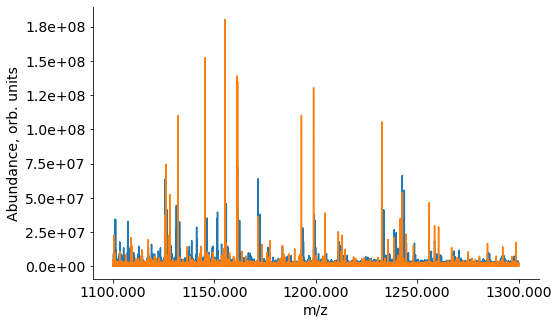

In [101]:
fig, ax = plt.subplots()
FullSp.plotmasskai(1100,1300,PlotTo=ax)
MonoSp.plotmasskai(1100,1300,PlotTo=ax)
plt.show()

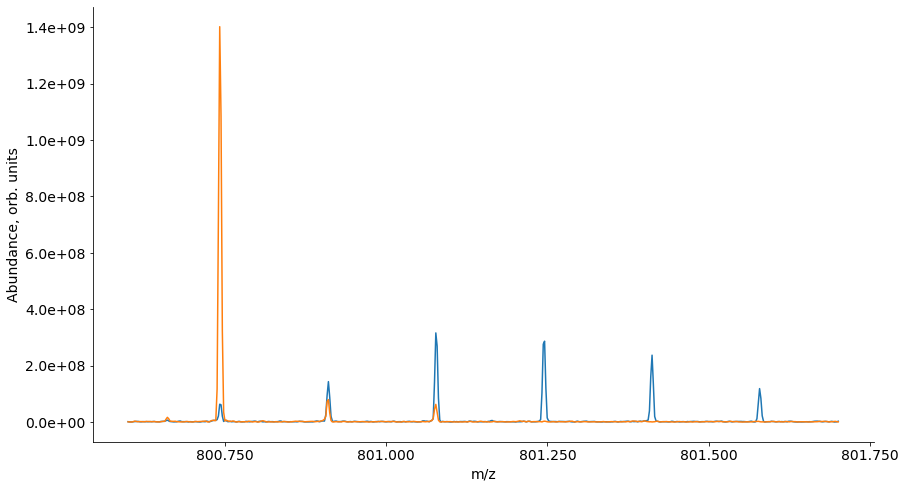

In [102]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots()
FullSp.plotmasskai(800.6,801.7,PlotTo=ax)
MonoSp.plotmasskai(800.6,801.7,PlotTo=ax)
plt.savefig("/results/Panel5-1.svg")
plt.show()

In [103]:
Proteins=[["MLYVIYAQDKADSLEKRLSVRPAHLARLQLLHDEGRLLTAGPMPAVDSNDPGAAGFTGSTVIAEFESLEAAQAWADADPYVAAGVYEHVSVKPFKKVF","Protein YciI","YciI"],
           ["MNKTQLIDVIAEKAELSKTQAKAALESTLAAITESLKEGDAVQLVGFGTFKVNHRAERTGRNPQTGKEIKIAAANVPAFVSGKALKDAVK","DNA-binding protein HU-alpha","HU-alpha"],
           ["MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVGFGTFAVKERAARTGRNPQTGKEITIAAAKVPSFRAGKALKDAVN","DNA-binding protein HU-beta","HU-beta"],
           ["S[+42.01056]ITKDQIIEAVAAMSVMDVVELISAMEEKFGVSAAAAVAVAAGPVEAAEEKTEFDVILKAAGANKVAVIKAVRGATGLGLKEAKDLVESAPAALKEGVSKDDAEALKKALEEAGAEVEVK","50S ribosomal protein L7-L12","50S L7-L12"],
           ["AKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI","Cold shock-like protein CspC","CspC"]]


In [104]:
AllPeaks=pd.DataFrame()
for i in range(5):
    trans=np.loadtxt("/data/{}_std_pept.csv".format(Proteins[i][1]),skiprows=2)[1000:]
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(Proteins[i][0],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    print(i,Proteins[i][2])
    Spec.TDACalc()
    AllPeaks = AllPeaks.append(Spec.RPeaks,ignore_index=True)

0 YciI



1 HU-alpha



2 HU-beta



3 50S L7-L12



4 CspC


In [105]:
AllPeaks=AllPeaks[AllPeaks["RSquare"]<-0.85]

In [106]:
AllPeaks=AllPeaks[np.isin(AllPeaks["Charge"],[1,2,3,4,5,6,7])]

In [107]:
plt.rcParams["figure.figsize"] = (12,7)

In [108]:
Fulllr=LogisticReg(AllPeaks)
Y,Y_Distr=Fulllr.Apply(AllPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	59 	 2.077 	 0.574
2 	113 	 2.908 	 0.930
3 	91 	 3.747 	 0.967
4 	81 	 3.956 	 1.062
5 	101 	 4.422 	 0.859
6 	102 	 5.496 	 0.807
7 	80 	 5.491 	 1.083
Resolution: 3.31


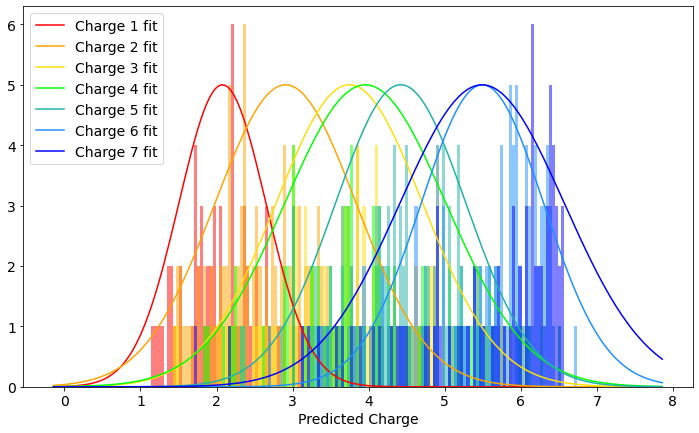

In [109]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5)

In [110]:
Fullmlr=MassLogisticReg(AllPeaks)
AllPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Fullmlr.Apply(AllPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	59 	 1.720 	 0.585
2 	113 	 2.579 	 0.873
3 	91 	 3.743 	 0.757
4 	81 	 4.064 	 0.935
5 	101 	 4.756 	 0.781
6 	102 	 5.564 	 0.826
7 	80 	 5.671 	 1.066
Resolution: 3.57


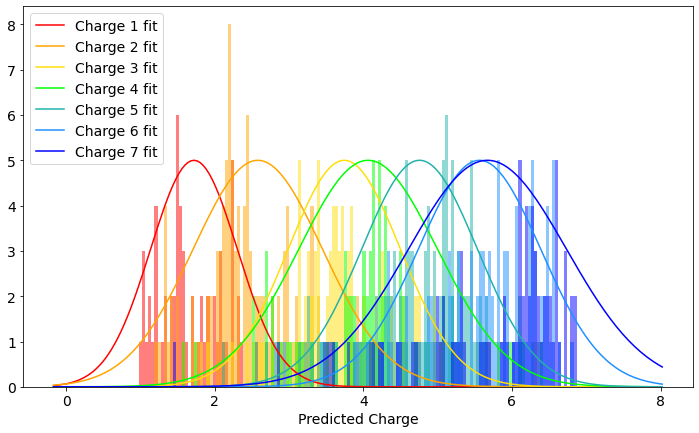

In [111]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="/results/Panel5-2.svg")

In [112]:
AllPeaks.to_csv("AllPeaks.csv",sep='\t')

In [113]:
AllIonPeaks=pd.DataFrame()
for i in range(len(Proteins)):
    trans=np.loadtxt("/data/{}_std_pept.csv".format(Proteins[i][1]),skiprows=2)[1000:]+np.loadtxt("/data/{}_std_prot.csv".format(Proteins[i][1]),skiprows=2)[1000:]
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(Proteins[i][0],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    
    trans=np.loadtxt("/data/{}_mono_pept.csv".format(Proteins[i][1]),skiprows=2)[1000:]
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.PeakPick(250,2500)
    MSpec.CheckIssues()
    MSpec.peaks = MSpec.peaks[~MSpec.peaks["issues"]]
    
    IonClusters=Spec.Clusters[(Spec.Clusters["Ions"] != "") & (Spec.Clusters["PPMError"] > -14) & (Spec.Clusters["PPMError"] < -7)]
    IonClusters["Mono m/z"]=(IonClusters["Mass"]/IonClusters["Charge"])+Proton
    IonClusters["m/z"]=0.
    IonClusters["Intensity"]=0.
    IonClusters["resolution"]=0.
    
    
    for row in IonClusters.iterrows():
        ppmlow=row[1]["Mono m/z"]-row[1]["Mono m/z"]/100000
        ppmhigh=row[1]["Mono m/z"]+row[1]["Mono m/z"]/100000
        localpeak=MSpec.peaks[(MSpec.peaks["m/z"]>ppmlow) & (MSpec.peaks["m/z"]<ppmhigh)]
        if len(localpeak) != 0: 
            IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
            IonClusters.at[row[0],"Intensity"]=localpeak.at[localpeak["Intensity"].idxmax(),"Intensity"]
            IonClusters.at[row[0],"resolution"]=localpeak.at[localpeak["Intensity"].idxmax(),"resolution"]
        else:
            IonClusters.at[row[0],"m/z"]=0.
    IonClusters=IonClusters[IonClusters["m/z"]>0.]
    print(i,Proteins[i][2])
    IonClusters = MSpec.TDACalc(Peaks = IonClusters)
    IonClusters.reset_index(inplace=True,drop=True)
    AllIonPeaks = AllIonPeaks.append(IonClusters,ignore_index=True)

0 YciI



1 HU-alpha



2 HU-beta



3 50S L7-L12



4 CspC


In [114]:
AllIonPeaks.to_csv("AllIonPeaks.csv",sep='\t')

In [115]:
AllIonPeaks=AllIonPeaks[AllIonPeaks["RSquare"]<-0.85]
AllIonPeaks=AllIonPeaks[np.isin(AllIonPeaks["Charge"],[1,2,3,4,5,6,7])]

In [116]:
AllIonPeaks.reset_index(inplace=True,drop=True)
Monolr=LogisticReg(AllIonPeaks)
AllIonPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Monolr.Apply(AllIonPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	92 	 1.682 	 0.453
2 	112 	 2.157 	 0.687
3 	70 	 2.895 	 0.735
4 	52 	 3.380 	 0.863
5 	41 	 4.335 	 0.810
6 	38 	 5.811 	 0.750
7 	22 	 6.714 	 0.235
Resolution: 4.59


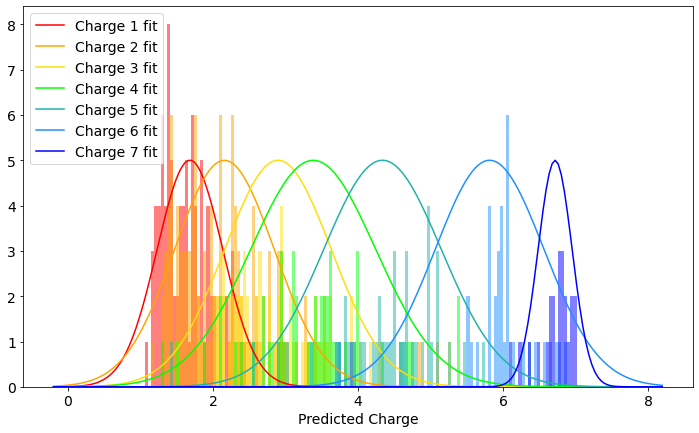

In [117]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5)

In [118]:
Monomlr=MassLogisticReg(AllIonPeaks)
Y,Y_Distr=Monomlr.Apply(AllIonPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	92 	 1.490 	 0.416
2 	112 	 2.114 	 0.609
3 	70 	 3.002 	 0.537
4 	52 	 3.623 	 0.695
5 	41 	 4.511 	 0.665
6 	38 	 5.872 	 0.615
7 	22 	 6.790 	 0.232
Resolution: 5.52


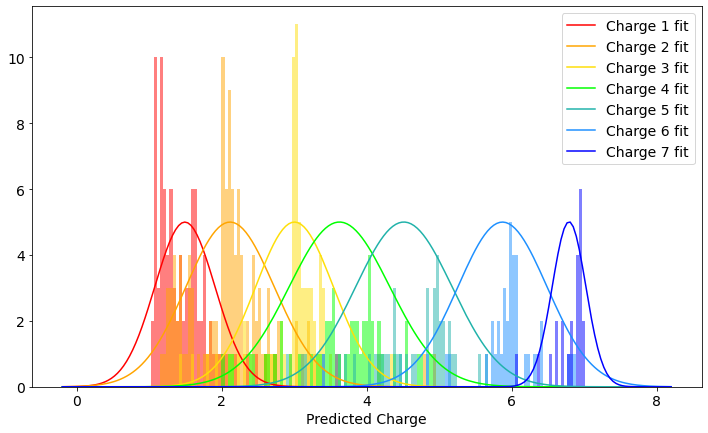

In [119]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="/results/Panel5-3.svg")

### Figure 6

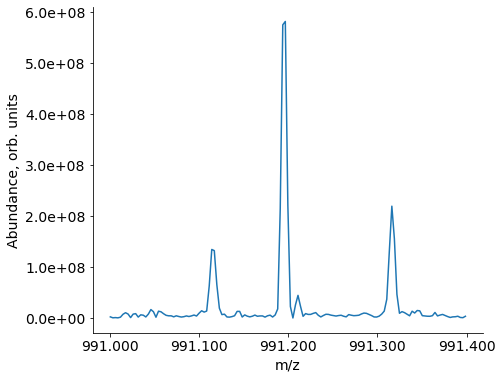

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [120]:
plt.rcParams["figure.figsize"] = (7,6)
UbiSpec.plotmasskai(991.,991.4,fname="/results/Panel6-1.svg")

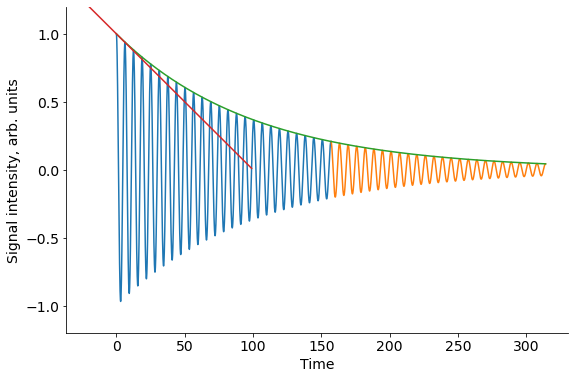

In [121]:
s1=np.arange(omega*resolution*2*(np.pi/2))/resolution
s2=np.arange(omega*resolution*2*(np.pi/2),omega*resolution*2*np.pi)/resolution
exp1=np.exp(-(s*tau))
plt.rcParams["figure.figsize"] = (9,6)
exp_sig1=np.cos(s1)*np.exp(-(s1*tau))
exp_sig2=np.cos(s2)*np.exp(-(s2*tau))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(top=1.2, bottom=-1.2)
plt.plot(s1,exp_sig1)
plt.plot(s2,exp_sig2)
plt.plot(s,exp1)
plt.ylabel("Signal intensity, arb. units")
plt.xlabel("Time")
slin = np.arange(-20,100)
lin=-(slin*tau)+1
slin=slin[lin>0.]
lin=lin[lin>0.]
plt.plot(slin,lin)
plt.savefig("/results/Panel6-2.svg")

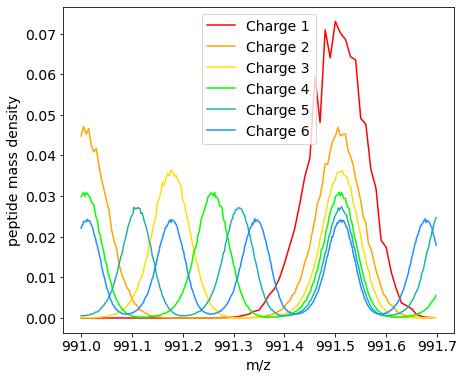

In [122]:
mz1=991.
mz2=991.6999
plt.rcParams["figure.figsize"] = (7,6)
MD=np.array(MassLogisticReg.MassDistr["0.2"])
for i in range(1,7):
    Mass1=(mz1-1.007276467)*i
    Mass2=(mz2-1.007276467)*i
    x=np.arange(mz1,mz2,0.01/i)
    plt.plot(x,MD[int(Mass1*100):int(Mass2*100)],colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("m/z")
plt.ylabel("peptide mass density")
plt.savefig("/results/Panel6-3.svg")

In [123]:
FRes.reset_index(drop=True,inplace=True)

In [124]:
FRes[(FRes["m/z"]>991)&(FRes["m/z"]<992)]

,m/z,Intensity,resolution,issues,cluster,number,rest,intensity,Mass,Charge,...,Ions,PPMError,Shift,TheorMass,Slope,Intercept,RSquare,Ratio,FWHM,FWHM Coeff
429,991.195479,640700672.0,141781.765625,False,1259,1,-0.000648,640700672.0,2969.5619,3,...,y26,-2.154105,0,2969.568297,-1.952339,7.229971,-0.994822,4.007422,0.006991,1.229955
430,991.864481,236878848.0,136094.609375,False,1259,3,-0.000352,236878848.0,2969.5619,3,...,y26,-2.154105,0,2969.568297,-2.737500,6.697708,-0.993382,6.003336,0.007288,1.263698


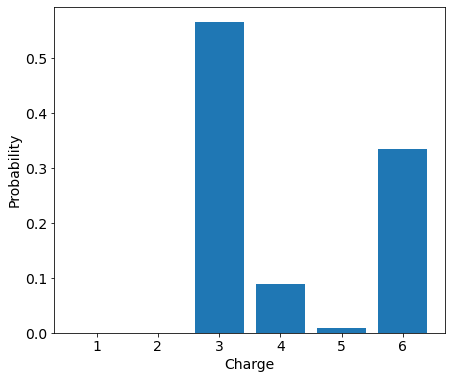

In [125]:
ind=429
Y_mass=np.zeros(6)
for i in range(6):
    Y_mass[i]=MassLogisticReg.MassDistr["0.2"][((FRes.loc[ind]["m/z"]-1.007276467)*(i+1)*100).astype(int)]
Y_mass=Y_mass/np.sum(Y_mass)
plt.bar([1,2,3,4,5,6],Y_mass[0:6])
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("/results/Panel6-4.svg")

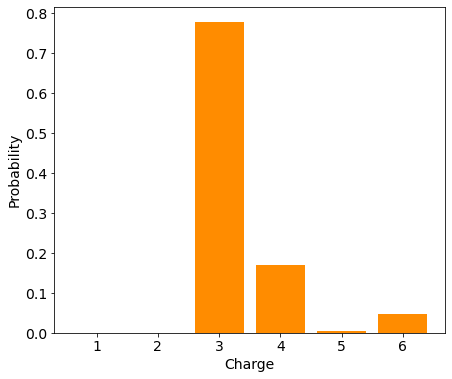

In [126]:
lrm=MassLogisticReg(FRes,FWHM=True,Slope=False)
FRes.reset_index(inplace=True,drop=True)
Y_mass,Y_Distr_mass=lrm.Apply(FRes)
plt.bar([1,2,3,4,5,6],Y_Distr_mass[ind][0:6],color="darkorange")
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("/results/Panel6-5.svg")

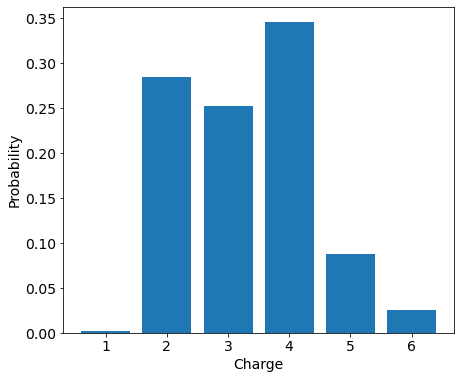

In [127]:
lr=LogisticReg(FRes,FWHM=True,Slope=False)
Y,Y_Distr=lr.Apply(FRes)
plt.bar([1,2,3,4,5,6],Y_Distr[ind][0:6])
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("/results/Panel6-6.svg")

Charge 	Peaks 	 Mean 	 Variance
1 	46 	 1.332 	 0.355
2 	80 	 2.350 	 0.990
3 	60 	 3.215 	 0.865
4 	65 	 4.193 	 0.978
5 	54 	 5.265 	 0.888
6 	79 	 5.802 	 1.029
7 	101 	 6.568 	 0.718
8 	36 	 7.582 	 0.570
Resolution: 4.25


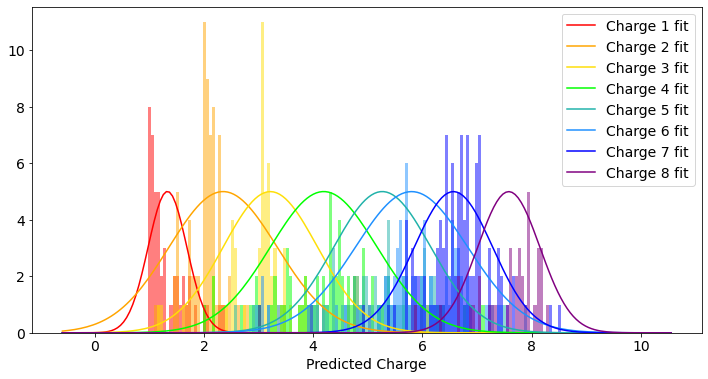

In [128]:
plt.rcParams["figure.figsize"] = (12,6)
ShowRes(Y_mass,FRes["Charge"],MaxCharge=8,GaussianHeght=5,fname="/results/Panel6-7.svg")

In [129]:
PeaksS3=UbiSpec.peaks[(UbiSpec.peaks["m/z"]>990)&(UbiSpec.peaks["m/z"]<992.7)]

In [130]:
PeaksS3=UbiSpec.TDACalc(Peaks=PeaksS3)

-0.875 7.875


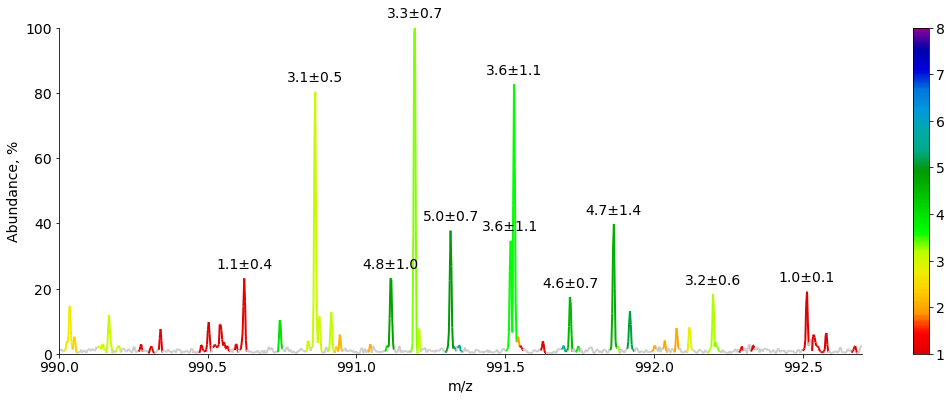

In [131]:
PeaksS3=lrm.Estimate(PeaksS3)
UbiSpec.RainbowSpectrum(990,992.7,PeaksS3,svg=True,Name="/results/Panel6-8")

### Figure S2

In [132]:
labels=FRes[(FRes["Ions"]=="y37")&(FRes["Charge"]==6)][["m/z","Slope"]]
labels = list(zip(list(labels["m/z"]),list(-labels["Slope"])))

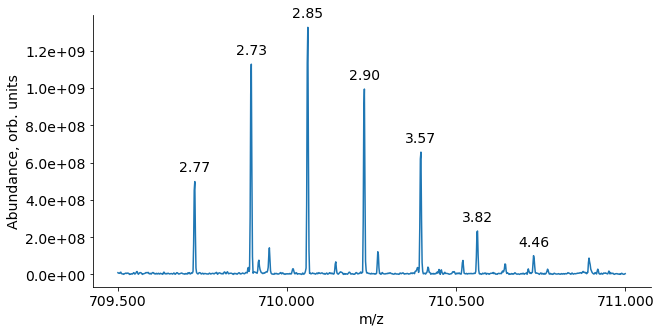

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [133]:
plt.rcParams["figure.figsize"] = (10,5)
UbiSpec.plotmasskai(709.5,711,labels=labels,fname="/results/PanelS2-1.svg")

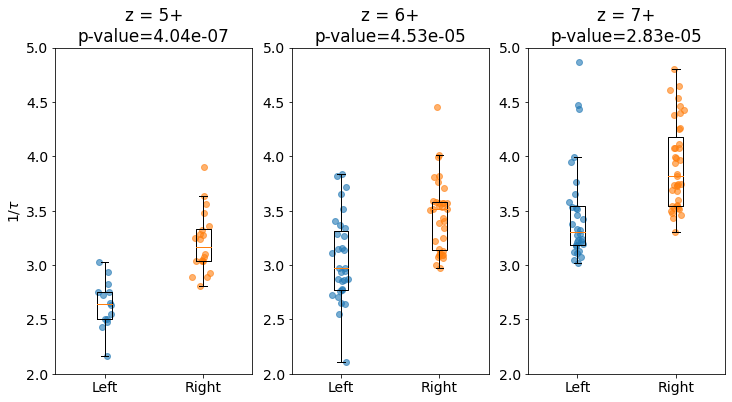

In [134]:
plt.rcParams["figure.figsize"] = (12,6)
Fig, (ax1,ax2,ax3) = plt.subplots(1,3)
plots=[ax1,ax2,ax3]
for charge in [5,6,7]:
    FResLefts=pd.DataFrame()
    FResRights=pd.DataFrame()
    FResPart = FRes[FRes["Charge"]==charge]
    #loop over isotopic clusters
    for ion in np.unique(FResPart["Ions"]):
        #Get m/z value of maximal signal in isotopic cluster
        MassMax=FResPart.loc[(FResPart[FResPart["Ions"]==ion]["intensity"].idxmax())]["m/z"]
        #Get left part of the cluster including peak pf maximum intensity (also filter by intensity to diminish intensity dependence)
        FResLefts=FResLefts.append(FResPart[(FResPart["Ions"]==ion)&(FResPart["m/z"]<=MassMax)&(FResPart["Intensity"]<=1.0e09)]) 
        #Get right part of the cluster
        FResRights=FResRights.append(FResPart[(FResPart["Ions"]==ion)&(FResPart["m/z"]>MassMax)&(FResPart["Intensity"]<=1.0e09)]) 
    Lefts=list(-FResLefts["Slope"])
    Rights=list(-FResRights["Slope"])
    stat,pvalue=stats.ttest_ind(Lefts,Rights)
    plots[charge-5].set_title("z = {}+\np-value={:.2e}".format(charge,pvalue))
    plots[charge-5].set_ylim(2,5)
    plots[charge-5].boxplot([Lefts,Rights],labels=["Left","Right"],showfliers=False)
    #plot points over box plot
    xs = np.random.normal( 1, 0.04, len(Lefts)) #jitter for value points - left part 
    plots[charge-5].scatter(xs,Lefts,color="C0",alpha=0.6)
    xs = np.random.normal( 2, 0.04, len(Rights)) #jitter for value points - right part
    plots[charge-5].scatter(xs,Rights,color="C1",alpha=0.6)
ax1.set_ylabel(r"1/$\tau$")
plt.savefig("/results/PanelS2-2.svg")

### Figure S3

In [135]:
MonoSp= TransSpectrum(np.loadtxt("/data/Cold shock-like protein CspC_mono_pept.csv",skiprows=2)[1000:])#4
MonoSp.A=2.117721546870e+14
FullSp = FullSpectrum(np.loadtxt("/data/Cold shock-like protein CspC_std_pept.csv",skiprows=2)[1000:])#+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,39))
FullSp.A=2.117721546870e+14

In [136]:
MonoSp.PeakPick(250,2500)
PPeaks=MonoSp.peaks[(MonoSp.peaks["m/z"]>850)&(MonoSp.peaks["m/z"]<900)&(MonoSp.peaks["Intensity"]>5.0e6)]

In [137]:
PPeaks=MonoSp.TDACalc(Peaks=PPeaks)

In [138]:
PPeaks.reset_index(inplace=True,drop=True)
PPeaks=Monomlr.Estimate(PPeaks)

-0.75 6.75


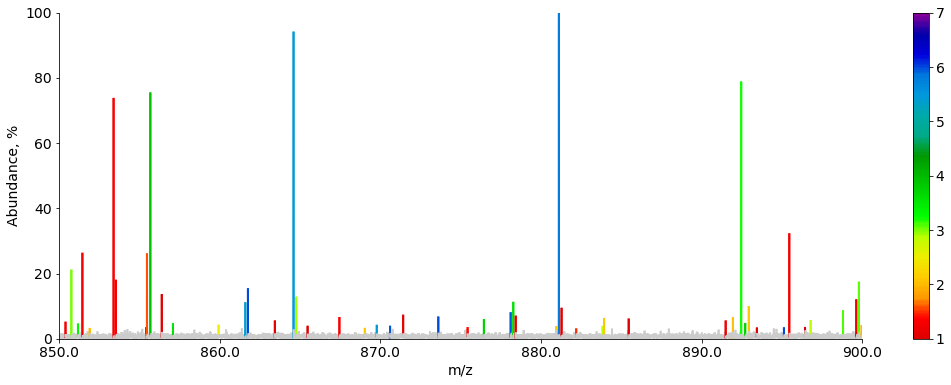

In [139]:
MonoSp.RainbowSpectrum(850,900,PPeaks,maxCharge=7,svg=True,Name="/results/PanelS3-1",LabelThres=1.)

-0.75 6.75


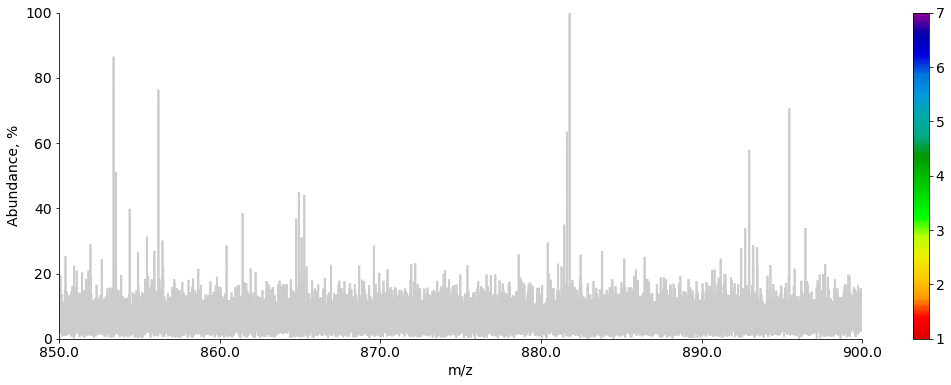

In [140]:
FullSp.RainbowSpectrum(850,900,PPeaks[PPeaks["m/z"]<0],maxCharge=7,svg=True,Name="/results/PanelS3-2")

### Table

In [141]:
Res = pd.DataFrame(columns=["Protein","Fragments","Sites","Coverage","Charda only fragments"])
for i in range(5):
    trans=np.loadtxt("/data/{}_mono_pept.csv".format(Proteins[i][1]),skiprows=2)[1000:]
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.PeakPick(250,2500,sn=2.)
    
    PPeaks=pd.read_csv("/data/MonoIons.{}.txt".format(Proteins[i][1]),sep="\t")
    FWHMCalc(PPeaks)
    PPeaks["Ions"]=""
    PPeaks["CHARDA Only"]=False
    YP,YP_distr=Monomlr.Apply(PPeaks)
    covers=[]
    for Charge in range(1,8):
        CPeaks=PPeaks[YP_distr[:,Charge-1]>0.1]
        CPeaks["Mass"]=(CPeaks["m/z"]-Proton)*Charge
        CPeaks["Charge"]=Charge
        CPeaks,cSet,cover=IonProducts(CPeaks,sequence=Proteins[i][0],ppm=20)
        Ions=CPeaks[CPeaks["Ions"]!=""]["Ions"]+" "+CPeaks[CPeaks["Ions"]!=""]["Charge"].apply(str)+"+"
        for ind in Ions.index:
            PPeaks["Ions"].iat[ind]=PPeaks["Ions"].iat[ind]+" "+Ions[ind]
            if MSpec.peaks[(MSpec.peaks["m/z"]-C13_Shift/Charge>PPeaks["m/z"].iat[ind]*0.99998)&(MSpec.peaks["m/z"]-C13_Shift/Charge<PPeaks["m/z"].iat[ind]*1.00002)].empty:
                PPeaks["CHARDA Only"].iat[ind]=True
        covers.append(cSet)
    Chrcover=[]
    for i1 in range(len(covers[0])):
        Prod=[]
        for j in range(len(covers)):
            Prod = Prod+covers[j][i1]
        Chrcover.insert(len(Chrcover),Prod)  
    frags=0
    sites=0
    for l in Chrcover:
        if len(l)>0:
            frags+=len(l)
            sites+=1
    Res.loc[i]=[Proteins[i][1],frags,sites,sites/len(Proteins[i][0]),len(PPeaks[PPeaks["CHARDA Only"]])]
Res

,Protein,Fragments,Sites,Coverage,Charda only fragments
0,Protein YciI,136,66,0.673469,85
1,DNA-binding protein HU-alpha,199,73,0.811111,80
2,DNA-binding protein HU-beta,297,77,0.855556,110
3,50S ribosomal protein L7-L12,288,108,0.824427,120
4,Cold shock-like protein CspC,203,62,0.911765,115


In [142]:
Res = pd.DataFrame(columns=["Protein","Fragments","Sites","Coverage","Clusters"])
APeaks=pd.DataFrame()
for i in range(5):
    MSpec=FullSpectrum(np.loadtxt("/data/{}_std_pept.csv".format(Proteins[i][1]),skiprows=2)[1000:])
    MSpec.A=2.117721546870e+14
    MSpec.PeakPick(250,2500,sn=2.)
    MSpec.CheckIssues()
    MSpec.RunHardKlor(charge_min=1,charge_max=10)
    clusters=len(MSpec.Clusters)
    CPeaks,cSet,cover=MSpec.Products(Proteins[i][0],ppm=20)
    APeaks=APeaks.append(CPeaks,ignore_index=True)
    frags=0
    sites=0
    for l in cSet:
        if len(l)>0:
            frags+=len(l)
            sites+=1
    Res.loc[i]=[Proteins[i][1],frags,sites,sites/len(Proteins[i][0]),clusters]
Res

,Protein,Fragments,Sites,Coverage,Clusters
0,Protein YciI,24,20,0.204082,221
1,DNA-binding protein HU-alpha,78,50,0.555556,506
2,DNA-binding protein HU-beta,107,47,0.522222,525
3,50S ribosomal protein L7-L12,72,46,0.351145,427
4,Cold shock-like protein CspC,42,30,0.441176,361
